## AC209a Data Science Project: Data Science with User Ratings and Reviews
Andrew Ross, Sophie Hilgard, Reiko Nishihara, Nick Hoernle

## Data source: 
We downloaded the data from the `Yelp Dataset Challenge' (https://www.yelp.com/dataset_challenge). The data contain in total 2.7M reviews from 687K users for 86K businesses. Business data consist of 15 features including ID, category of business (e.g., fast food, restaurant, nightlife, etc.), city, full address, operation hours, latitude, longitude, review count, and stars earned. User data consist of 11 features including average stars, compliments, elite, number of fans, IDs of his/her friends, name, review count, vote categories, and the month start a yelp review. 

## Data Exploration

In [9]:
import mpl_toolkits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import matplotlib
import collections
import ast
#install basemap
from mpl_toolkits.basemap import Basemap
from load_yelp_data import load_yelp_dataframe
%matplotlib inline

In [8]:
businesses = load_yelp_dataframe('businesses').drop('Unnamed: 0', 1)
reviews = load_yelp_dataframe('reviews').drop('Unnamed: 0', 1)
users = load_yelp_dataframe('users').drop('Unnamed: 0', 1)

In [7]:
print 'Reviews dataframe shape', reviews.shape
reviews.head(2)

Reviews dataframe shape (2685066, 6)


,user_id,business_id,year,month,day,stars
0,511457,0,2012,8,1,4
1,291005,0,2014,2,13,5


In [8]:
print 'Businesses dataframe shape', businesses.shape
businesses.head(2)

Businesses dataframe shape (85901, 15)


,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
0,"{'Accepts Credit Cards': True, 'Noise Level': ...",0,"['Fast Food', 'Restaurants']",Dravosburg,"4734 Lebanon Church Rd\nDravosburg, PA 15034","{'Monday': {'close': '21:00', 'open': '11:00'}...",40.354327,-79.900706,Mr Hoagie,[],True,7,3.5,PA,business
1,"{'Accepts Credit Cards': True, 'Price Range': ...",1,['Nightlife'],Dravosburg,"202 McClure St\nDravosburg, PA 15034",{},40.350553,-79.886814,Clancy's Pub,[],True,5,3.0,PA,business


In [9]:
print 'Users dataframe shape', users.shape
users.head(2)

Users dataframe shape (686556, 11)


,average_stars,compliments,elite,fans,friends,name,review_count,type,user_id,votes,yelping_since
0,4.14,"{'plain': 25, 'writer': 9, 'cute': 15, 'photos...","[2005, 2006]",69,"[1, 2, 3, 5, 93, 12, 99, 464, 1025, 1298, 1388...",Russel,108,user,0,"{'cool': 246, 'useful': 282, 'funny': 167}",2004-10
1,3.67,"{'plain': 970, 'writer': 346, 'cute': 204, 'ph...","[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",1345,"[0, 2, 3, 4, 5, 6, 8, 9, 12, 95, 97, 187, 465,...",Jeremy,1292,user,1,"{'cool': 12091, 'useful': 15242, 'funny': 8399}",2004-10


In [10]:
users.drop('user_id', axis=1).describe()

,average_stars,fans,review_count
count,686556.000000,686556.000000,686556.000000
mean,3.746704,1.290100,25.757102
std,1.086832,11.501621,83.755973
min,0.000000,0.000000,0.000000
25%,3.230000,0.000000,2.000000
50%,3.920000,0.000000,5.000000
75%,4.600000,0.000000,17.000000
max,5.000000,3549.000000,10897.000000


In [11]:
businesses.drop(['latitude', 'longitude', 'business_id'], axis=1).describe()

,open,review_count,stars
count,85901,85901.000000,85901.000000
mean,0.852272,34.352359,3.694852
std,0.354832,108.677591,0.946045
min,False,3.000000,1.000000
25%,1,5.000000,3.000000
50%,1,10.000000,4.000000
75%,1,26.000000,4.500000
max,True,6200.000000,5.000000


The table of the users data shows that median value of stars was 3.74 (inter-quartile range, IQR, was 3.2 - 4.6), median value of fans was 0 (IQR, 0 - 0), and median review counts was 5 (IQR, 2 - 17). This indicates that most reviewers do not have fans and most wrote a small number of reviews.

Furthermore, for the businesses, we see that 85% of the businesses are open, and the mean rating for businesses is 3.69. The IQR for business ratings is 3 to 4.5.

**Analysis of reviews per business and user**

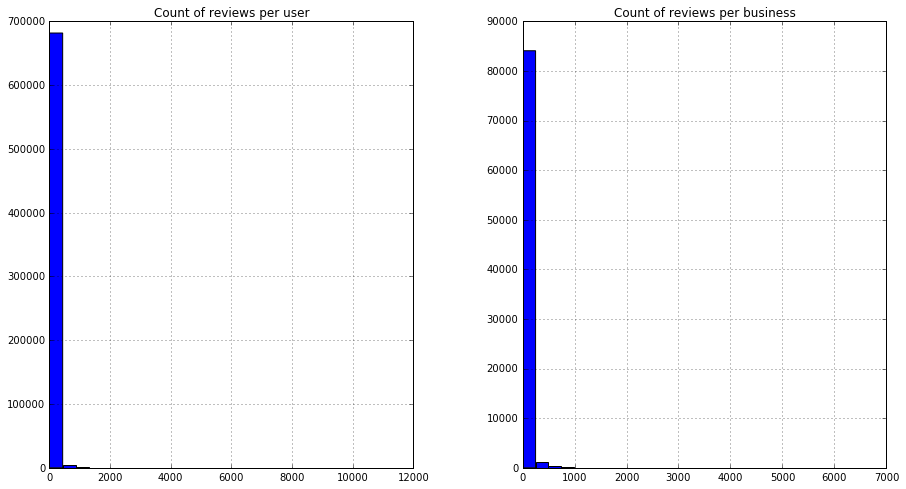

In [16]:
fig, axes = plt.subplots(1,2, figsize=(15,8))
users.hist(column='review_count',
           ax=axes[0],
           bins=25)
businesses.hist(column='review_count',
                ax=axes[1],
                bins=25)

axes[0].set_title('Count of reviews per user')
axes[1].set_title('Count of reviews per business')
plt.show()
# histogram of reviews per user and reviews per business

We see a spread from 0 to 12000 reviews for the users and a spread from 0 to 7000 reviews for businesses. If we remove some outliers the picture of typical number of reviews per user and business may become more clear. The two quartiles are more representative of the truth for both of these datasets. We wish to look at the percentiles between the 10th and the 90th percentile to understand the distribution of review per user and business:

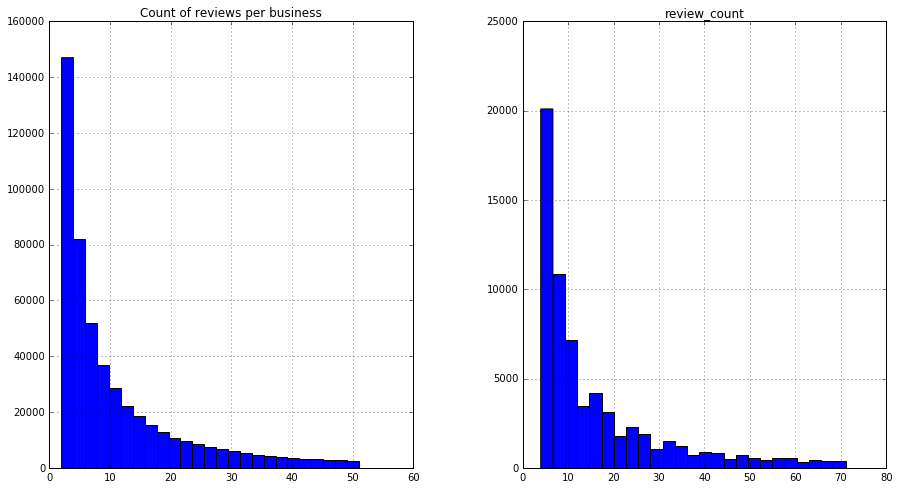

In [17]:
user_q10, user_q90 = users['review_count'].quantile(q=[0.1,0.9])
business_q10, business_q90 = businesses['review_count'].quantile(q=[0.1,0.9])
fig, axes = plt.subplots(1,2, figsize=(15,8))

users_reduced = users[((users['review_count'] > user_q10) & (users['review_count'] < user_q90))]
businesses_reduced = businesses[((businesses['review_count'] > business_q10) & (businesses['review_count'] < business_q90))]

users_reduced.hist(column='review_count',
           ax=axes[0],
           bins=25)
businesses_reduced.hist(column='review_count',
                ax=axes[1],
                bins=25)

axes[0].set_title('Count of reviews per user')
axes[0].set_title('Count of reviews per business')
plt.show()

Figures for the count of reviews per user and count of reviews per business show a unimodal distribution with fatter tail in the right side. Most reviewers tend to write a small number of reviews, and therefore most businesses got a small number of reviews. A question that arises from this plot: for the businesses that receive a high number of ratings, are the ratings more or less positive than the businesses that receive a low number of ratings? The same question can be asked of the users.

In [18]:
low_users_count = users[(users['review_count'] > 2) & (users['review_count'] < 20)]
high_users_count = users[(users['review_count'] > 40) & (users['review_count'] < 200)]

low_business_count = businesses[(businesses['review_count'] > 2) & (businesses['review_count'] < 20)]
high_business_count = businesses[(businesses['review_count'] > 40) & (businesses['review_count'] < 200)]

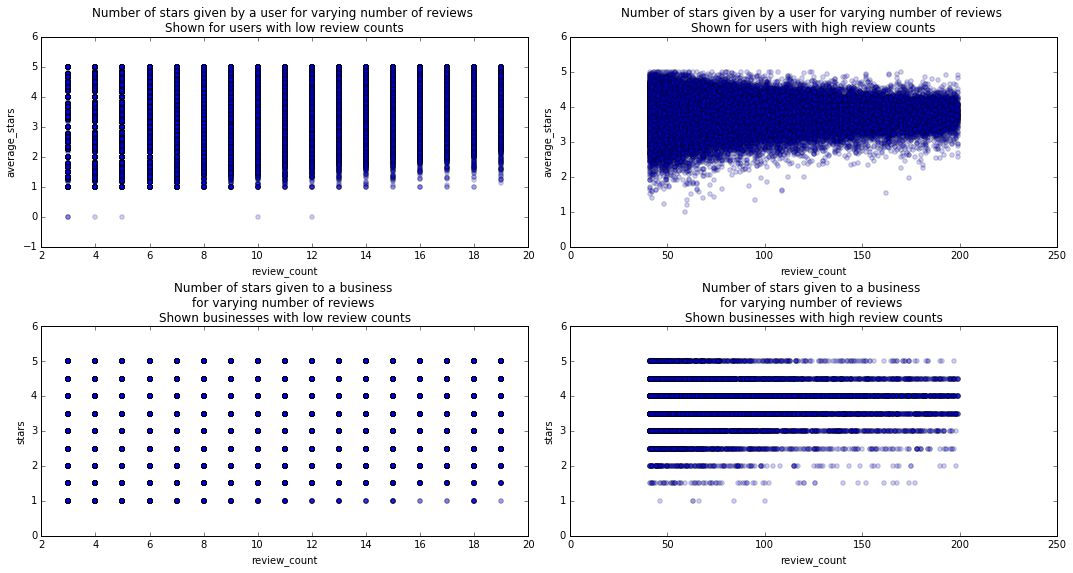

In [21]:
fig, axes = plt.subplots(2,2, figsize=(15,8))

low_users_count.plot('review_count', 'average_stars', kind='scatter', ax=axes[0,0], alpha=0.2)
high_users_count.plot('review_count', 'average_stars', kind='scatter', ax=axes[0,1], alpha=0.2)

low_business_count.plot('review_count', 'stars', kind='scatter', ax=axes[1,0], alpha=0.2)
high_business_count.plot('review_count', 'stars', kind='scatter', ax=axes[1,1], alpha=0.2)

axes[0,0].set_title('Number of stars given by a user for varying number of reviews \nShown for users with low review counts')
axes[0,1].set_title('Number of stars given by a user for varying number of reviews \nShown for users with high review counts')

axes[1,0].set_title('Number of stars given to a business \nfor varying number of reviews \nShown businesses with low review counts')
axes[1,1].set_title('Number of stars given to a business \nfor varying number of reviews \nShown businesses with high review counts')

fig.tight_layout()
plt.show()

From the above charts, we see that as the number of reviews given to a business increases, the average review will tend to the user given average. Simply by the central limit theorem this is an expected result.

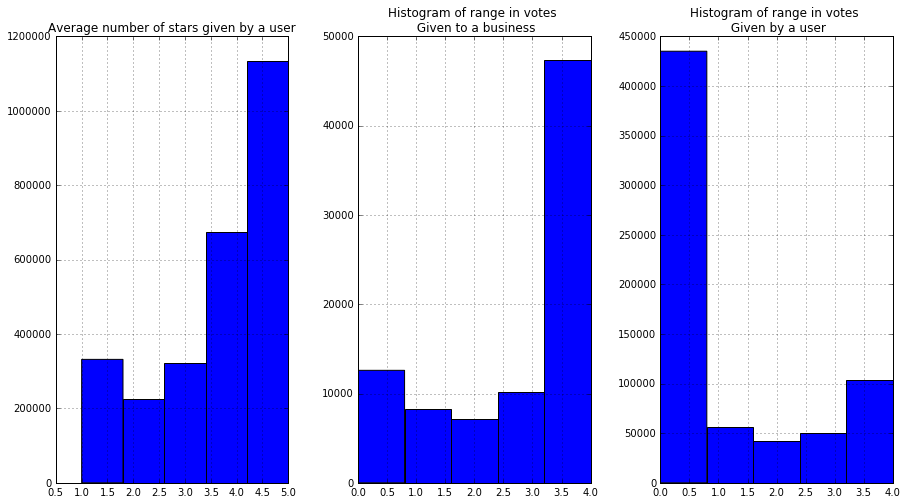

In [187]:
range_in_business_votes = reviews.groupby(['business_id']).agg({"stars": lambda x: np.max(x)-np.min(x)})
range_in_user_votes = reviews.groupby(['user_id']).agg({"stars": lambda x: np.max(x)-np.min(x)})

fig, axes = plt.subplots(1,3, figsize=(15,8))
reviews.hist(column='stars', ax=axes[0], bins=5)
range_in_business_votes.hist(column='stars', ax=axes[1], bins=5)
range_in_user_votes.hist(column='stars', ax=axes[2], bins=5)

axes[0].set_title('Average number of stars given by a user')
axes[1].set_title('Histogram of range in votes \n Given to a business')
axes[2].set_title('Histogram of range in votes \n Given by a user')

plt.show()

We see that users typically rate businesses highly (with a clear mode being 5 stars). However, we also note that businesses have a high range of votes (a mode of 4 indicates that users differ in their opinions). The figure also shows that users did not change their rating schema based on the business, and the majority of users rate all businesses within 1 point of each other - this suggests that the rating from a any one user is more dependent on the user than on the business.

**Confirm the above plots for high-usage users:**

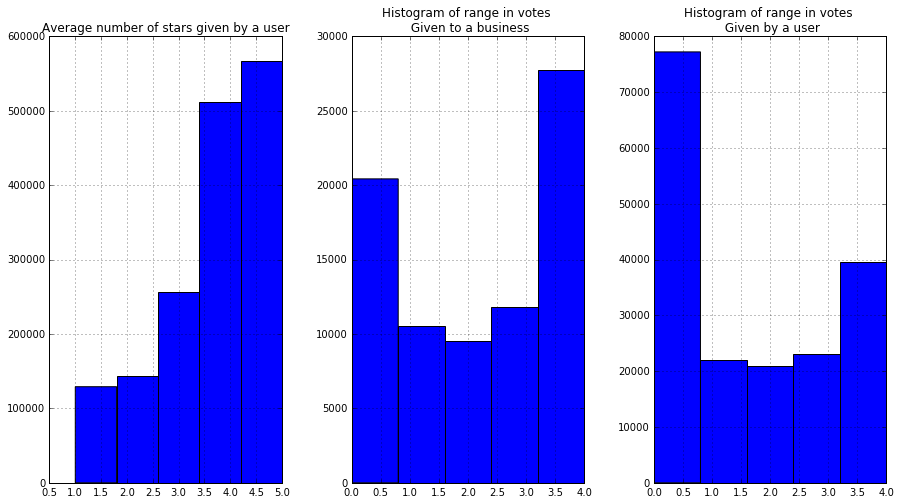

In [35]:
user_ids_of_high_users = users[users.review_count > 15][['user_id']]
reviews_from_high_users = pd.merge(reviews, user_ids_of_high_users, on='user_id', how='inner')

range_in_business_votes = reviews_from_high_users.groupby(['business_id']).agg({"stars": lambda x: np.max(x)-np.min(x)})
range_in_user_votes = reviews_from_high_users.groupby(['user_id']).agg({"stars": lambda x: np.max(x)-np.min(x)})

fig, axes = plt.subplots(1,3, figsize=(15,8))
reviews_from_high_users.hist(column='stars', ax=axes[0], bins=5)
range_in_business_votes.hist(column='stars', ax=axes[1], bins=5)
range_in_user_votes.hist(column='stars', ax=axes[2], bins=5)

axes[0].set_title('Average number of stars given by a user')
axes[1].set_title('Histogram of range in votes \n Given to a business')
axes[2].set_title('Histogram of range in votes \n Given by a user')

plt.show()

We propose that the users who do not change their vote for businesses are unhelpful to an analysis model and thus should be excluded from the dataset.

**Finding the top and bottom rated Businesses:**

In [36]:
def find_mode(values, num_bins):
    bins, edges = np.histogram(values, bins=num_bins)
    max_height_index = np.argmax(bins)
    mode = (edges[max_height_index] + edges[max_height_index + 1]) / 2.
    return mode

def sample_posterior(row, a, b, n_samples):
    stars = row['sum']
    total_ratings = row['count_nonzero']
    post_samples = np.random.beta(a + stars, b + (total_ratings - stars), n_samples)
    return find_mode(post_samples, 10)

Using a prior that assumes businesses will not be enjoyed (we wich to overcompensate for the average high ratings of users) we are able to build a more comprehensive likelyhood and thus filter the review somewhat into a more confident top and bottom grouping. The ratings alone are unreliable and we rather wish to include the number of times a business has been rated in a particular manner to calculate the likelihood that this is a favorable (or not) business). 

For example, if a business is rated poorly twice, this is an unreliable statistic and we do not wish to penalise the business from a median likelihood too dramatically. On the contrary, if a business is rated poorly 100 times, we are confident that users rate the business poorly and we wish to have a low likelihood for enjoyment.

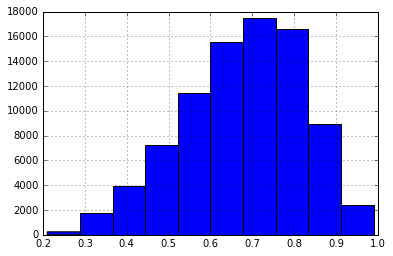

In [37]:
n_samples = 1000
a,b=8,8
businesses_sum_reviews = reviews.groupby(['business_id']).agg({"stars": [np.sum, np.count_nonzero]})['stars']
businesses_sum_reviews['count_nonzero'] *= 5
businesses_percentage_rating = businesses_sum_reviews.apply(sample_posterior, axis=1, args=(a, b, n_samples))
businesses_percentage_rating.hist(bins=10)

We now see a distribution that corresponds to a probability that this is a good business (i.e. users will like it). On the low end of the scale we have a small number of very poor businesses. We note that these businesses will have a large number of poor ratings. Similarily, on the high end, we see that there is a relatively small number of highly rated businesses. These businesses require a high number of very positive ratings to be rated into this category.

We note that we used a fairly aggressive prior assumption that all businesses have a median probability for being liked that is less than 2.5. This is to overcompensate for the generally high ratings. We now have a more normally distributed dataset 

In [195]:
# Worst 5 businesses by rating
businesses_percentage_rating.sort_values(inplace=True)
businesses[businesses['business_id'].isin(businesses_percentage_rating[:5].index)]

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
38013,{'Accepts Credit Cards': True},38013,"['Local Services', 'Shipping Centers', 'Courie...",Phoenix,"3401 E Harbour Dr\nPhoenix, AZ 85034","{'Monday': {'close': '21:00', 'open': '06:30'}...",33.418617,-112.008369,OnTrac,[],True,348,1,AZ,business
42348,{'By Appointment Only': False},42348,"['Medical Centers', 'Health & Medical']",Mesa,"6859 E Rembrandt Ave\nMesa, AZ 85212",{},33.340693,-111.684094,The Breast Cancer Society,[],False,28,1,AZ,business
42758,{'Accepts Credit Cards': True},42758,"['Security Systems', 'Home Services']",Youngtown,"12810 N 113th Ave\nYoungtown, AZ 85363",{},33.600873,-112.302024,Monitronics Security,[],True,22,1,AZ,business
44140,{},44140,"['Hotels & Travel', 'Travel Services']",Las Vegas,"4305 Dean Martin Dr\nSte 155\nLas Vegas, NV 89103",{},36.111109,-115.181755,Expedia Local Expert,[],False,26,1,NV,business
79558,{'Accepts Credit Cards': False},79558,"['Local Services', 'Data Recovery', 'IT Servic...",Phoenix,"2375 E Camelback Rd\nSte 600\nPhoenix, AZ 85016","{'Monday': {'close': '18:00', 'open': '08:00'}...",33.508909,-112.030650,Website Backup,[],True,63,1,AZ,business


In [196]:
# top 5 businesses by rating
businesses[businesses['business_id'].isin(businesses_percentage_rating[-5:].index)]

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
62649,"{'Accepts Credit Cards': True, 'By Appointment...",62649,"['Roofing', 'Home Services']",Phoenix,"22402 N 24th Ave\nPhoenix, AZ 85027","{'Monday': {'close': '17:00', 'open': '08:00'}...",33.689519,-112.110450,Stell Roofing,[],True,121,5,AZ,business
81053,"{'Accepts Credit Cards': True, 'Wheelchair Acc...",81053,"['Skin Care', 'Beauty & Spas', 'Hair Removal',...",Las Vegas,6670 S Tenaya Way\nSte 190\nSpring Valley\nLas...,"{'Monday': {'close': '20:00', 'open': '10:00'}...",36.067134,-115.251043,Simply Skin Las Vegas,['Spring Valley'],True,151,5,NV,business
81236,"{'Accepts Credit Cards': True, 'Wheelchair Acc...",81236,"['Active Life', 'Challenge Courses']",Las Vegas,"4375 S Valley View Blvd\nLas Vegas, NV 89103","{'Friday': {'close': '21:30', 'open': '09:00'}...",36.110228,-115.191387,Adventure Combat Ops,[],True,124,5,NV,business
81498,"{'Accepts Credit Cards': True, 'Wheelchair Acc...",81498,"['Henna Artists', 'Hair Removal', 'Event Plann...",Henderson,790 Coronado Center Dr\nSte 140\nAnthem\nHende...,"{'Monday': {'close': '20:00', 'open': '10:00'}...",36.002963,-115.107726,Khina Eyebrow Threading & Henna Art,['Anthem'],True,133,5,NV,business
82912,{'Accepts Credit Cards': True},82912,"['Local Services', 'Appliances & Repair']",Henderson,"Henderson, NV 89011","{'Monday': {'close': '19:30', 'open': '07:30'}...",36.103626,-114.939821,Absolute Appliance Services,[],True,105,5,NV,business


We will later assess: 1) Does rating affect open vs closed? 2) Does location affect open vs closed? 3) Does location/rating affect open vs closed?

## Time series analysis:

In [197]:
# Add a useful date column to the review data
reviews['date']=pd.to_datetime(reviews.year*10000+reviews.month*100+reviews.day,format='%Y%m%d')

earliest_review = reviews.iloc[reviews.date.argmin()]
latest_review = reviews.iloc[reviews.date.argmax()]
print 'Reviews from %i/%i/%i to %i/%i/%i' % (earliest_review.year, earliest_review.month, earliest_review.day, 
                                            latest_review.year, latest_review.month, latest_review.day)

Reviews from 2004/10/12 to 2016/7/19


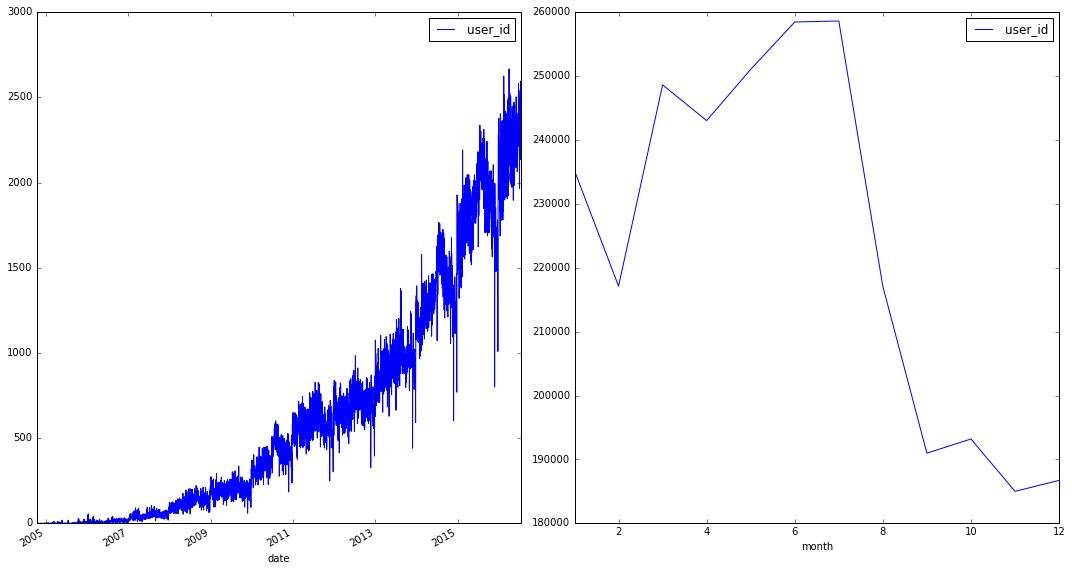

In [198]:
fig, axes = plt.subplots(1,2, figsize=(15,8))

day_groups = reviews.groupby('date')
month_groups = reviews.groupby('month')

reviews_per_day = day_groups.agg({'user_id': np.count_nonzero})
reviews_over_months = month_groups.agg({'user_id': np.count_nonzero})

reviews_per_day.plot(ax=axes[0])
reviews_over_months.plot(ax=axes[1])

fig.tight_layout()

Now, we incorporated time axis on the data and conducted simple analyses. First, we noticed that yelp review has become more popular over time, and possibly, June and July are the most popular months.

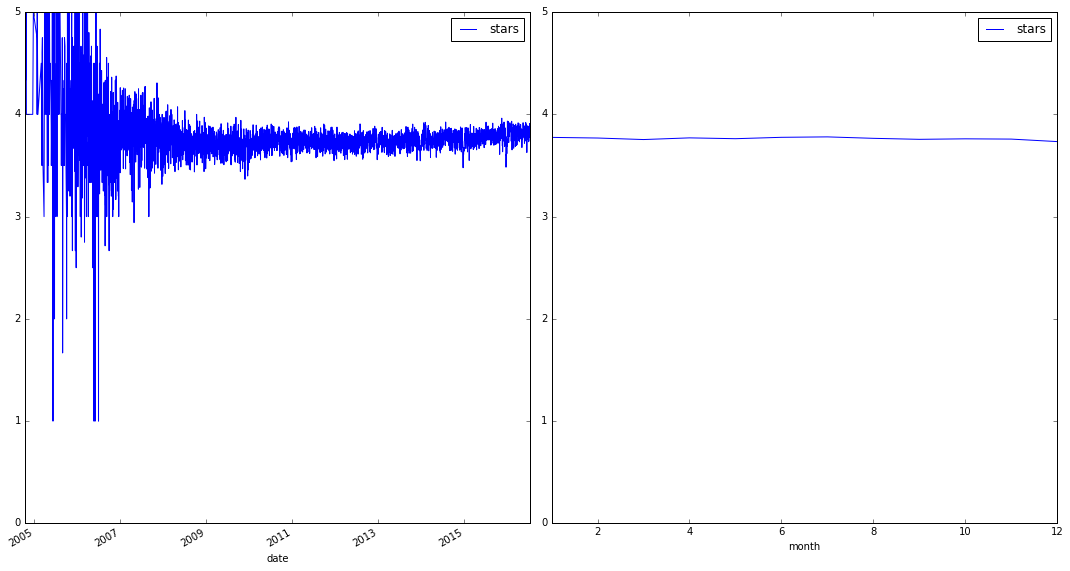

In [199]:
fig, axes = plt.subplots(1,2, figsize=(15,8))

day_groups = reviews.groupby('date')
month_groups = reviews.groupby('month')

reviews_per_day = day_groups.agg({'stars': np.mean})
reviews_over_months = month_groups.agg({'stars': np.mean})

reviews_per_day.plot(ax=axes[0])
reviews_over_months.plot(ax=axes[1])

axes[1].set_ylim([0,5])
axes[0].set_ylim([0,5])

fig.tight_layout()

In earlier years (i.e., before 2008), the average stars varied very widely from 1 to 5 stars. In contrast, after 2009 onward, the average stars converged to around 4. This is mainly because we have more reviews over time and the mean value became less variable. The rating did not differ according to the month reviewed.

In [200]:
# Group the dataframe by users and then businesses
user_bus_grouped = reviews.groupby(['user_id', 'business_id'])
user_bus_stars_mean_and_count = user_bus_grouped.agg({'stars': [np.mean, np.count_nonzero]})

In [201]:
# For each user count the number of unique ratings and compare this to the total number of ratings
reviews_per_bus = reviews.groupby(['user_id']).business_id.size()/reviews.groupby(['user_id']).business_id.nunique()
reviews_per_bus.describe()

count    686556.000000
mean          1.017483
std           0.112315
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          11.000000
dtype: float64

/Users/nickhoernle/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


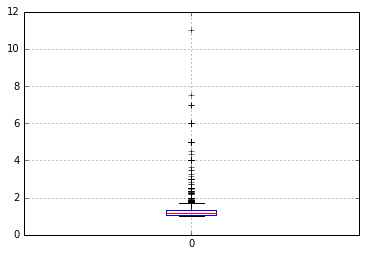

In [202]:
pd.DataFrame(reviews_per_bus[reviews_per_bus!=1]).boxplot()
plt.show()

Majority of reviews are once off. For the users that returned:

When we analyzed the number of repeated reviews by a user, we found that majority of reviews reviewed once.

### Checkins
- Checkins to reviews (interpret checkins - do you visit places regularily)
- Interpret checkins as review (is it neutral)


### Business Type:

### Location
What does this do between cities and within cities


In [10]:
# Classify the datapoints into the cities based on the latitude and the longitude
cities = np.array([['Edinburgh', 55.9533, -3.1883, 0, 0],
         ['Karlsruhe', 49.0069, 8.4037, 0, 0],
         ['Montreal', 45.5017, -73.5673, 0, 0],
         ['Waterloo', 43.4643, -80.5204, 0, 0],
         ['Pittsburgh', 40.4406, -79.9959, 0, 0],
         ['Charlotte', 35.2271, -80.8431, 0, 0],
         ['Urbana-Champaign', 40.1106, -88.2073, 0, -150000],
         ['Phoenix', 33.4484, -112.0740, 0, 0],
         ['Las Vegas', 36.1699, -115.1398, 0, 0],
         ['Madison', 43.0731, -89.4012, 0, 0]])
lat = np.array(cities[:,1], np.float32)
lon = np.array(cities[:,2], np.float32)
x_offsets = np.array(cities[:,3], np.float32)
y_offsets = np.array(cities[:,4], np.float32)

def classify_datapoint_by_latitude_and_longitude(datapoint):
#     print datapoint
    latitude = datapoint['latitude']
    longitude = datapoint['longitude']
    distances = (latitude - lat)**2 + (longitude - lon)**2
    min_dist = np.argmin(distances)
    return cities[min_dist, 0]

businesses['location'] = businesses.apply(classify_datapoint_by_latitude_and_longitude, axis=1)

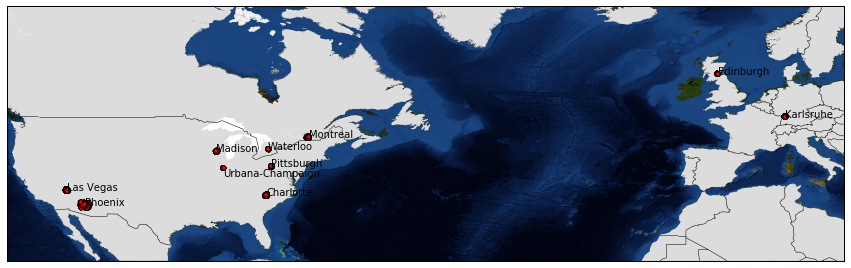

In [20]:
## Plot all of the cities

fig = plt.figure(figsize=(15,10))

business_map = Basemap(projection='gall',
#                        width=12000000,height=9000000,
                      llcrnrlon = businesses.longitude.min()-10,   # lower-left corner longitude
                      llcrnrlat = businesses.latitude.min()-10,    # lower-left corner latitude
                      urcrnrlon = businesses.longitude.max()+10,   # upper-right corner longitude
                      urcrnrlat = businesses.latitude.max()+10,    # upper-right corner latitude
                      resolution = 'l',
                      area_thresh = 100000.0,
              )

business_map.drawcountries()
business_map.fillcontinents(color = 'gainsboro')
business_map.drawmapboundary(fill_color='steelblue')

x, y = business_map(np.array(businesses.longitude), np.array(businesses.latitude))

business_map.plot(x, y, 
            'o',                    # marker shape
            color='red',         # marker colour
            markersize=4            # marker size
            )

x, y = business_map(lon, lat)
for label, xpt, ypt, x_offset, y_offset in zip(cities[:,0], x, y, x_offsets, y_offsets):
    plt.text(xpt+x_offset, ypt+y_offset, label)

business_map.bluemarble()
plt.show()

We see that we are given 10 hubs from the yelp data. From the metatdata about this database we know that these correspond to:

 - U.K.: Edinburgh
 - Germany: Karlsruhe
 - Canada: 
     - Montreal 
     - Waterloo
 - U.S.: 
     - Pittsburgh, 
     - Charlotte, 
     - Urbana-Champaign, 
     - Phoenix, 
     - Las Vegas, 
     - Madison

In [11]:
businesses[['business_id','location']].groupby('location').agg(['count'])

,business_id
,count
location,
Charlotte,7160
Edinburgh,3480
Karlsruhe,1074
Las Vegas,23598
Madison,3067
Montreal,5592
Phoenix,36505
Pittsburgh,4088


Purely on numbers of reviews it is worthwhile narrowing our location based study to 'Las Vegas' and 'Phoenix'.

In [12]:
vegas_businesses = businesses[businesses.location == 'Las Vegas']
phoenix_businesses = businesses[businesses.location == 'Phoenix']

# extract the categories set
categories = collections.Counter()
def increment(categories, category):
    categories[category] += 1
[[increment(categories, category.strip()) for category in ast.literal_eval(c)] for c in phoenix_businesses.categories]
categories

most_common_categories = categories.most_common()[:10]
print most_common_categories

[('Restaurants', 9428), ('Shopping', 5424), ('Food', 3637), ('Beauty & Spas', 3603), ('Home Services', 3466), ('Health & Medical', 3420), ('Automotive', 2629), ('Local Services', 2119), ('Nightlife', 1599), ('Active Life', 1551)]


/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


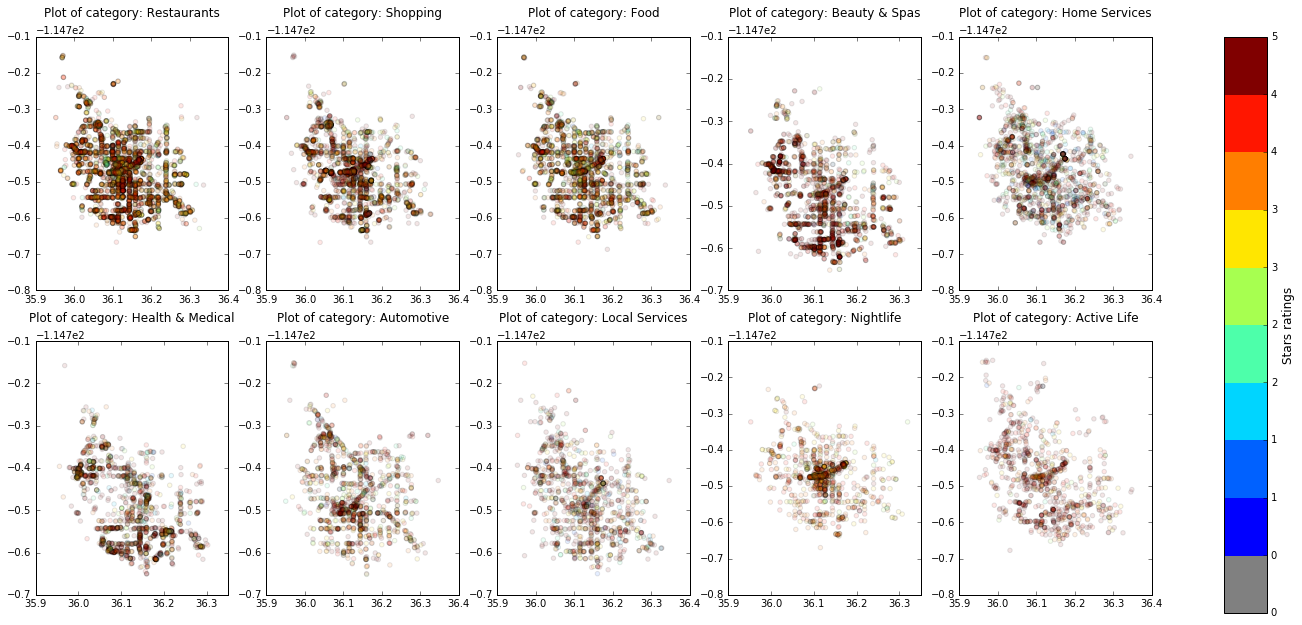

In [13]:
bus_reduced = businesses[(businesses.location == 'Las Vegas')]

fig, axes = plt.subplots(2,5, figsize=(20,10))
axes = axes.flatten()

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,5,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

i = 0
alpha = 0.1
for category, number in most_common_categories:
    bus_reduced[category] = bus_reduced.categories.apply( lambda x: category in x)
    businesses_for_category = bus_reduced[bus_reduced[category] == 1]
    axes[i].scatter(businesses_for_category.latitude, 
                    businesses_for_category.longitude, 
                    label=category, 
                    alpha=alpha,
                    c=businesses_for_category.stars,
                    cmap=cmap, 
                    norm=norm)
    axes[i].set_title('Plot of category: ' + category + '\n')
    i+=1

ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = matplotlib.colorbar.ColorbarBase(ax2, 
                               cmap=cmap, 
                               norm=norm, 
                               spacing='proportional', 
                               ticks=bounds, 
                               boundaries=bounds, 
                               format='%1i')

ax2.set_ylabel('Stars ratings', size=12)
    
# fig.tight_layout()
plt.show()

/Users/nickhoernle/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


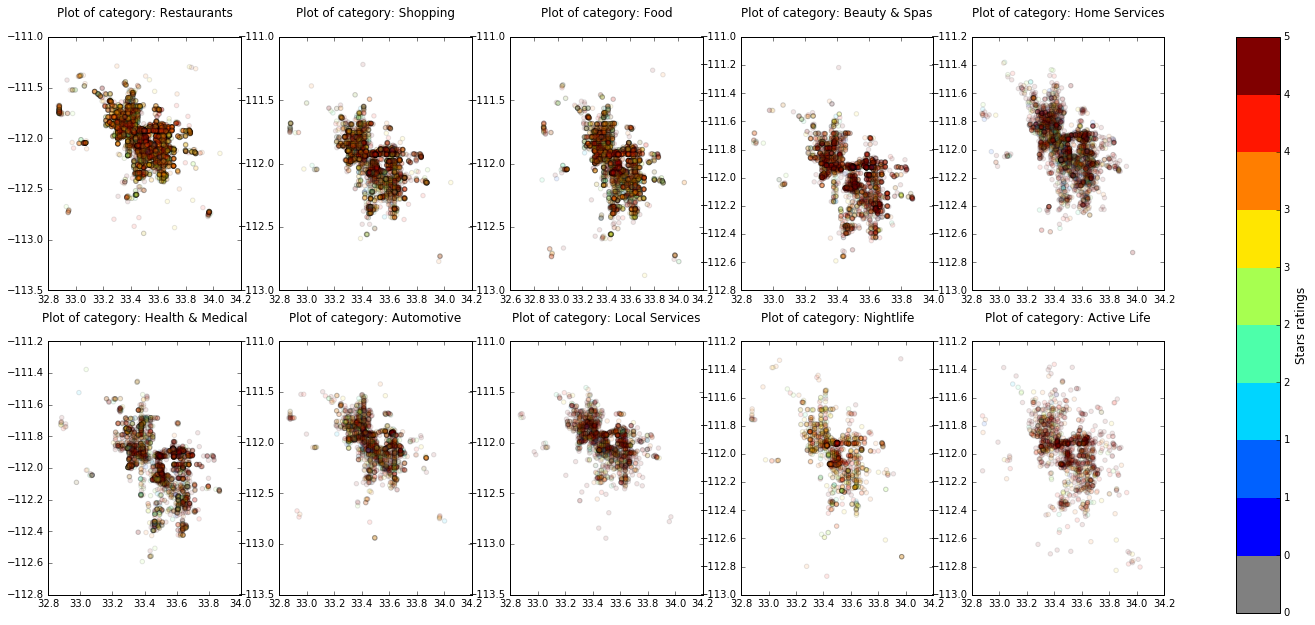

In [114]:
bus_reduced = businesses[(businesses.location == 'Phoenix')]

fig, axes = plt.subplots(2,5, figsize=(20,10))
axes = axes.flatten()

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,5,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

i = 0
alpha = 0.1
for category, number in most_common_categories:
    bus_reduced[category] = bus_reduced.categories.apply( lambda x: category in x)
    businesses_for_category = bus_reduced[bus_reduced[category] == 1]
    axes[i].scatter(businesses_for_category.latitude, 
                    businesses_for_category.longitude, 
                    label=category, 
                    alpha=alpha,
                    c=businesses_for_category.stars,
                    cmap=cmap, 
                    norm=norm)
    axes[i].set_title('Plot of category: ' + category + '\n')
    i+=1

ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = matplotlib.colorbar.ColorbarBase(ax2, 
                               cmap=cmap, 
                               norm=norm, 
                               spacing='proportional', 
                               ticks=bounds, 
                               boundaries=bounds, 
                               format='%1i')

ax2.set_ylabel('Stars ratings', size=12)
    
# fig.tight_layout()
plt.show()

Phoenix forms a much more ceneter hub of all of the businesses whereas Las Vegas is more spread out within the setting

In [1]:
import folium
from IPython.display import HTML

def display(m, height=300):
    """Takes a folium instance and embed HTML."""
    m._build_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{0}" '
                 'style="width: 100%; height: {1}px; '
                 'border: none"></iframe>'.format(srcdoc, height))
    return embed

In [46]:
from folium import features
import numpy as np
import os

# indexes = businesses.full_address.apply( lambda(x): ', NV' in x.split('\n')[-1] )

# businesses[indexes]['latitude'], businesses[indexes]['longitude']

bus_reduced = businesses[(businesses.location == 'Las Vegas')]


i = 0
alpha = 0.1
for category, number in most_common_categories:
    bus_reduced[category] = bus_reduced.categories.apply( lambda x: category in x)
    businesses_for_category = bus_reduced[bus_reduced[category] == 1]
    axes[i].scatter(businesses_for_category.latitude, 
                    businesses_for_category.longitude, 
                    label=category, 
                    alpha=alpha,
                    c=businesses_for_category.stars,
                    cmap=cmap, 
                    norm=norm)
    axes[i].set_title('Plot of category: ' + category + '\n')
    i+=1

# data = {
#     "type": "FeatureCollection",
#     "features": [
#         {
#             "type": "Feature",
#             "geometry": {
#                 "type": "MultiPoint",
#                 "coordinates": [[lon, lat] for (lat, lon) in zip(bus_reduced[bus_reduced['Restaurants'] == 1]['latitude'][:100], bus_reduced[bus_reduced['Restaurants'] == 1]['longitude'][:100])],
#             },
#             "properties": {"color":'#000000',
#                     "fill_color":'#000000'}
#         },
#     ],
# }

rest_data = bus_reduced[bus_reduced['Restaurants'] == 1]
shopping_data = bus_reduced[bus_reduced['Shopping'] == 1]
nl_data = bus_reduced[bus_reduced['Nightlife'] == 1]
hm_data = bus_reduced[bus_reduced['Health & Medical'] == 1]

# print rest_data[:5]['stars']

# print rest_data.iloc[0]['latitude']

m = folium.Map(location=[36.1699, -115.1398], zoom_start=10)
# m.add_child(features.GeoJson(data))
# for i in range(0,len(rest_data)):
for i in range(0,len(rest_data)/10):
    folium.Marker([rest_data.iloc[i]['latitude'], rest_data.iloc[i]['longitude']],
          #Make color/style changes here
          icon = folium.Icon(color='green'),
          ).add_to(m)
    
# for i in range(0,50):
#     folium.Marker([rest_data.iloc[-i]['latitude'], rest_data.iloc[-i]['longitude']],
#           #Make color/style changes here
#           icon = folium.Icon(color='red'),
#           ).add_to(m)
    
for i in range(0,len(shopping_data)/10):
    folium.Marker([shopping_data.iloc[i]['latitude'], shopping_data.iloc[i]['longitude']],
          #Make color/style changes here
          icon = folium.Icon(color='red'),
          ).add_to(m)

for i in range(0,len(nl_data)/10):
    folium.Marker([nl_data.iloc[i]['latitude'], nl_data.iloc[i]['longitude']],
      #Make color/style changes here
      icon = folium.Icon(color='black'),
      ).add_to(m)
    
# for i in range(0,50):
#     folium.Marker([nl_data.iloc[-i]['latitude'], nl_data.iloc[-i]['longitude']],
#       #Make color/style changes here
#       icon = folium.Icon(color='black'),
#       ).add_to(m)
    
for i in range(0,len(hm_data)/10):
    folium.Marker([hm_data.iloc[i]['latitude'], hm_data.iloc[i]['longitude']],
      #Make color/style changes here
      icon = folium.Icon(color='blue'),
      ).add_to(m)

m.save(os.path.join('./results', 'Features_7.html'))

m

/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Here we see a plot of a subset of a few business types in Las Vegas by type. Green is Restaurants, Red is Shopping, Black is Nightlife, and Blue is Medical.

Restaurants (and to a lesser extent Shopping) appear all over the map, but Nightlife is definitely clustered and Medical seems to have a higher probability of lying outside the highly-trafficked areas, which we would expect.

In [48]:
rest_data = bus_reduced[bus_reduced['Restaurants'] == 1].sort('stars', ascending=0)
rest_data_closed = rest_data[rest_data['open']==False]
shopping_data = bus_reduced[bus_reduced['Shopping'] == 1].sort('stars', ascending=0)
nl_data = bus_reduced[bus_reduced['Nightlife'] == 1].sort('stars', ascending=0)
hm_data = bus_reduced[bus_reduced['Health & Medical'] == 1].sort('stars', ascending=0)

m = folium.Map(location=[36.1699, -115.1398], zoom_start=11)
# m.add_child(features.GeoJson(data))
# for i in range(0,len(rest_data)):
for i in range(0,100):
    folium.Marker([rest_data.iloc[i]['latitude'], rest_data.iloc[i]['longitude']],
          #Make color/style changes here
          icon = folium.Icon(color='green'),
          ).add_to(m)
    
for i in range(0,100):
    folium.Marker([rest_data.iloc[-i]['latitude'], rest_data.iloc[-i]['longitude']],
          #Make color/style changes here
          icon = folium.Icon(color='red'),
          ).add_to(m)

for i in range(0,100):
    folium.Marker([rest_data_closed.iloc[-i]['latitude'], rest_data_closed.iloc[-i]['longitude']],
          #Make color/style changes here
          icon = folium.Icon(color='black'),
          ).add_to(m)
       
m.save(os.path.join('./results', 'Features_7.html'))

m

/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In this plot, we look at restaurants in particular. Green are the best-rated restaurants, Red are the worst-rated restaurants, and Black are closed restaurants. Notice that closed restaurants do appear to be farther away from the city center on average, implying that less foot traffic is going to lead to a higher probability of restaurants closing, as we'd expect.

In [52]:
rest_data = bus_reduced[bus_reduced['Restaurants'] == 1].sort('review_count', ascending=0)
rest_data_closed = rest_data[rest_data['open']==False]
shopping_data = bus_reduced[bus_reduced['Shopping'] == 1].sort('review_count', ascending=0)
nl_data = bus_reduced[bus_reduced['Nightlife'] == 1].sort('review_count', ascending=0)
hm_data = bus_reduced[bus_reduced['Health & Medical'] == 1].sort('review_count', ascending=0)

m = folium.Map(location=[36.1699, -115.1398], zoom_start=11)
# m.add_child(features.GeoJson(data))
# for i in range(0,len(rest_data)):
for i in range(0,100):
    folium.Marker([rest_data.iloc[i]['latitude'], rest_data.iloc[i]['longitude']],
          #Make color/style changes here
          icon = folium.Icon(color='green'),
          ).add_to(m)
    
for i in range(0,100):
    folium.Marker([shopping_data.iloc[i]['latitude'], shopping_data.iloc[i]['longitude']],
          #Make color/style changes here
          icon = folium.Icon(color='red'),
          ).add_to(m)

for i in range(0,100):
    folium.Marker([nl_data.iloc[i]['latitude'], nl_data.iloc[i]['longitude']],
          #Make color/style changes here
          icon = folium.Icon(color='black'),
          ).add_to(m)
       
m.save(os.path.join('./results', 'Features_7.html'))

m

/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


These are the most-reviewed businesses in each category. They're surprisingly spread out, to me, especially for Shopping. This is likely because highly reviewed "shopping" spots are going to be Costco, Target, etc, which tend to 

In [15]:
for category, number in most_common_categories:
    print category
    bus_reduced[category] = bus_reduced.categories.apply( lambda x: category in x)
    

Restaurants
Shopping


/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Food
Beauty & Spas
Home Services
Health & Medical
Automotive
Local Services
Nightlife
Active Life
